In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import seaborn as sns
from IPython.display import Image, display
# other
from scipy.stats import ttest_ind, t, pearsonr

# Path to modules
sys.path.append('../modules')
# Import my modules
from teleconnections import build_teleconnection_df
from timeseries import select_months
from statistical_tests import pearsonr_autocorrelation

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures

# USE pandas.options TO DISPLAY FLOATS TO TWO DECIMAL PLACES
pd.options.display.float_format = "{:,.2f}".format

In [3]:
start_date = '1979-03-01'
end_date = '2018-05-31'

tele = build_teleconnection_df('seasonal', 'ANOM', start_date, end_date)
tele

,AO,PDO,ENSO,SH
date,,,,
1979-03-01,-0.71,-0.08,0.19,-2.01
1979-06-01,0.08,0.19,0.18,-2.01
1979-09-01,-0.27,0.85,0.54,-2.01
1979-12-01,-0.54,0.23,0.46,0.05
1980-03-01,-0.97,0.68,0.44,0.05
...,...,...,...,...
2017-03-01,0.18,0.37,0.35,-0.55
2017-06-01,0.38,-0.24,-0.14,-0.55
2017-09-01,0.05,-0.49,-0.85,-0.55


In [4]:
df_index_djf = select_months(tele, 12, 2)
df_index_mam = select_months(tele, 3, 5)
df_index_djfmam = select_months(tele, 12, 5)
print('# DJF days: ', len(df_index_djf))
print('# MAM days: ', len(df_index_mam))
print('# DJFMAM days: ', len(df_index_djfmam))

# DJF days:  39
# MAM days:  40
# DJFMAM days:  79


In [5]:
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

In [8]:
def ar_annual_df(ssn, nk):
    ## Import csv
    out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
    filepath = out_path + 'AR-types_ALLDAYS.csv'
    df = pd.read_csv(filepath)

    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))

    ## Total typecount
    typelist = [1, 2, 3]
    ntypes = len(typelist)
    type_count = df['AR_CAT'].value_counts()
    print(type_count)

    # percentages
    totdays = np.sum(type_count)
    type_freq = type_count / totdays
    print(type_freq*100)
    
    ## Break up columns into different AR Types
    keys = []
    for k in range(nk):
        keys.append("AR_CAT{:1d}".format(k+1,))

    values = np.zeros((len(df.index)))
    dicts = dict(zip(keys, values))

    df_cat = pd.DataFrame(dicts, index=df.index)

    for k in range(nk):
        idx = (df['AR_CAT'] == k+1)
        col = "AR_CAT{:1d}".format(k+1,)
        df_cat.loc[idx, col] = 1
    
    ## resamples data to quarterly
    df_ann = df_cat.resample('QS-DEC').sum()
    freq = df_cat.resample('QS-DEC').count()
    
    # select current season
    if ssn == 'djf':
        idx = (df_ann.index.month == 12)
    elif ssn == 'mam':
        idx = (df_ann.index.month == 3)
    elif ssn == 'djfmam':
        idx = (df_ann.index.month == 3) | (df_ann.index.month == 12)
    
    df_ann = df_ann.loc[idx]
    # get total of all AR types
    df_ann['AR_ALL'] = df_ann['AR_CAT1'] + df_ann['AR_CAT2'] + df_ann['AR_CAT3']
    
    return df_ann

In [9]:
df_djf = ar_annual_df(ssn='djf', nk=3)
df_mam = ar_annual_df(ssn='mam', nk=3)
df_djfmam = ar_annual_df(ssn='djfmam', nk=3)

0    3165
3     169
2      94
1      92
Name: AR_CAT, dtype: int64
0   89.91
3    4.80
2    2.67
1    2.61
Name: AR_CAT, dtype: float64
0    3288
2     132
3     130
1     130
Name: AR_CAT, dtype: int64
0   89.35
2    3.59
3    3.53
1    3.53
Name: AR_CAT, dtype: float64
0    6369
2     270
1     250
3     219
Name: AR_CAT, dtype: int64
0   89.60
2    3.80
1    3.52
3    3.08
Name: AR_CAT, dtype: float64


In [10]:
# combine ar annual df with ao annual df
print(len(df_djf), len(df_mam), len(df_index_djf), len(df_index_mam))
# join indices with AR count
new_djf = df_djf.join(df_index_djf)
new_mam = df_mam.join(df_index_mam)
new_djfmam = df_djfmam.join(df_index_djfmam)

39 40 39 40


In [11]:
# ## TO DO: ADD el nino mean, la nina mean, neutral mean, 5-year running mean

# fname = path_to_figs + 'ENSO_barplot_' + ssn
# fmt = 'png'
# fig = plt.figure()
# fig.set_size_inches((8.5,11.0))
# fig.dpi = 300
# nplots=4

# artype = ['AR_CAT1', 'AR_CAT2', 'AR_CAT3', 'total']
# ssn_label = ['AR Type 1', 'AR Type 2', 'AR Type 3', 'All Types']
# flatui = ['grey', 'red', 'c']

# for i in np.arange(nplots):
#     ax = fig.add_subplot(4, 1, i+1)
#     data = df2_ssn
#     sns.barplot(x=data.index.year, y=data[artype[i]], hue=data['ENSO_CAT'],
#                 data=data, palette=flatui, dodge=False)
#     sns.set_style("ticks")
#     ax.set_ylabel('# of AR Days', fontsize=12)
#     ax.set_xlabel('')

#     # Format the x axis
#     ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
# #     ax.xaxis.set_major_formatter(DateFormatter('%Y'))
#     ax.set_xticklabels(np.arange(1975, 2020, 5), fontsize=12)
#     ax.legend(loc='upper center')
#     plt.gca().legend().set_title('')
#     plt.ylim(0, 30)
#     ax.set_title(ssn_label[i], loc='left')
    
# plt.tight_layout()
# # Save the figure
# fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
# fig.clf()

# plotFile = fname + '.png'
# print(plotFile)
# display(Image(plotFile))

In [12]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    pval = dfcols.transpose().join(dfcols, how='outer')
    tval = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            tval[r][c], pval[r][c] = pearsonr_autocorrelation(df[r], df[c], alpha=0.05, autocorr=True)
    return pvalues, pval

In [13]:
## correlations between indices and AR frequency
corrMatrix = new_djf.corr()
corrMatrix

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,1.00,-0.15,0.31,0.60,0.36,-0.29,-0.01,-0.08
AR_CAT2,-0.15,1.00,-0.08,0.31,-0.18,0.13,0.20,0.06
AR_CAT3,0.31,-0.08,1.00,0.83,0.28,0.03,0.34,-0.17
AR_ALL,0.60,0.31,0.83,1.00,0.29,-0.05,0.33,-0.13
AO,0.36,-0.18,0.28,0.29,1.00,-0.32,-0.16,-0.26
PDO,-0.29,0.13,0.03,-0.05,-0.32,1.00,0.44,-0.02
ENSO,-0.01,0.20,0.34,0.33,-0.16,0.44,1.00,-0.24
SH,-0.08,0.06,-0.17,-0.13,-0.26,-0.02,-0.24,1.00


In [14]:
# calculate two-tailed pvalues with F test
pval, pval2 = calculate_pvalues(new_djf)
pval2

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,NaN,0.27,0.10,0.00,0.04,0.22,0.94,0.74
AR_CAT2,0.27,NaN,0.61,0.16,0.18,0.46,0.11,0.68
AR_CAT3,0.10,0.61,NaN,0.00,0.12,0.91,0.08,0.46
AR_ALL,0.00,0.16,0.00,NaN,0.20,0.86,0.20,0.64
AO,0.04,0.18,0.12,0.20,NaN,0.09,0.32,0.18
PDO,0.22,0.46,0.91,0.86,0.09,NaN,0.01,0.91
ENSO,0.94,0.11,0.08,0.20,0.32,0.01,NaN,0.17
SH,0.74,0.68,0.46,0.64,0.18,0.91,0.17,NaN


In [15]:
## correlations between indices and AR frequency
corrMatrix = new_mam.corr()
corrMatrix

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,1.00,-0.11,0.06,0.54,0.12,0.32,0.50,-0.24
AR_CAT2,-0.11,1.00,0.12,0.60,-0.10,0.26,0.13,0.13
AR_CAT3,0.06,0.12,1.00,0.62,-0.07,0.26,0.03,-0.21
AR_ALL,0.54,0.60,0.62,1.00,-0.03,0.48,0.38,-0.17
AO,0.12,-0.10,-0.07,-0.03,1.00,-0.28,0.13,-0.27
PDO,0.32,0.26,0.26,0.48,-0.28,1.00,0.44,0.00
ENSO,0.50,0.13,0.03,0.38,0.13,0.44,1.00,-0.40
SH,-0.24,0.13,-0.21,-0.17,-0.27,0.00,-0.40,1.00


In [16]:
# calculate two-tailed pvalues with F test
pval, pval2 = calculate_pvalues(new_djf)
pval2

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,NaN,0.27,0.10,0.00,0.04,0.22,0.94,0.74
AR_CAT2,0.27,NaN,0.61,0.16,0.18,0.46,0.11,0.68
AR_CAT3,0.10,0.61,NaN,0.00,0.12,0.91,0.08,0.46
AR_ALL,0.00,0.16,0.00,NaN,0.20,0.86,0.20,0.64
AO,0.04,0.18,0.12,0.20,NaN,0.09,0.32,0.18
PDO,0.22,0.46,0.91,0.86,0.09,NaN,0.01,0.91
ENSO,0.94,0.11,0.08,0.20,0.32,0.01,NaN,0.17
SH,0.74,0.68,0.46,0.64,0.18,0.91,0.17,NaN


In [17]:
## correlations between indices and AR frequency
corrMatrix = new_djfmam.corr()
corrMatrix

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,1.00,-0.06,0.15,0.58,-0.11,0.20,0.08,-0.05
AR_CAT2,-0.06,1.00,0.01,0.62,0.20,0.14,0.42,-0.25
AR_CAT3,0.15,0.01,1.00,0.58,0.19,0.04,0.05,0.04
AR_ALL,0.58,0.62,0.58,1.00,0.16,0.21,0.34,-0.17
AO,-0.11,0.20,0.19,0.16,1.00,-0.29,-0.07,-0.30
PDO,0.20,0.14,0.04,0.21,-0.29,1.00,0.43,-0.01
ENSO,0.08,0.42,0.05,0.34,-0.07,0.43,1.00,-0.29
SH,-0.05,-0.25,0.04,-0.17,-0.30,-0.01,-0.29,1.00


In [18]:
# calculate two-tailed pvalues with F test
pval, pval2 = calculate_pvalues(new_djfmam)
pval2

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,NaN,0.54,0.21,0.00,0.33,0.09,0.48,0.72
AR_CAT2,0.54,NaN,0.95,0.00,0.11,0.28,0.00,0.08
AR_CAT3,0.21,0.95,NaN,0.00,0.11,0.79,0.71,0.79
AR_ALL,0.00,0.00,0.00,NaN,0.28,0.16,0.02,0.31
AO,0.33,0.11,0.11,0.28,NaN,0.09,0.60,0.09
PDO,0.09,0.28,0.79,0.16,0.09,NaN,0.03,0.95
ENSO,0.48,0.00,0.71,0.02,0.60,0.03,NaN,0.20
SH,0.72,0.08,0.79,0.31,0.09,0.95,0.20,NaN


In [19]:
## 5 year rolling mean
data_roll_djf = new_djf.rolling(5).mean()

## correlations between indices and AR frequency
corrMatrix = data_roll_djf.corr()
corrMatrix

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,1.00,0.24,0.58,0.81,0.53,-0.41,0.32,-0.44
AR_CAT2,0.24,1.00,0.17,0.47,0.19,-0.42,0.19,-0.08
AR_CAT3,0.58,0.17,1.00,0.89,0.73,-0.04,0.50,-0.65
AR_ALL,0.81,0.47,0.89,1.00,0.71,-0.30,0.48,-0.60
AO,0.53,0.19,0.73,0.71,1.00,-0.10,0.43,-0.75
PDO,-0.41,-0.42,-0.04,-0.30,-0.10,1.00,0.46,0.01
ENSO,0.32,0.19,0.50,0.48,0.43,0.46,1.00,-0.36
SH,-0.44,-0.08,-0.65,-0.60,-0.75,0.01,-0.36,1.00


In [20]:
# calculate two-tailed pvalues with F test
pval, pval2 = calculate_pvalues(data_roll_djf)
pval2

../modules/statistical_tests.py:189: RuntimeWarning: invalid value encountered in sqrt
  s_T = np.sqrt((1-r**2)/df)


,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,NaN,0.76,0.49,0.63,0.61,0.99,0.82,NaN
AR_CAT2,0.76,NaN,0.91,NaN,0.77,NaN,0.86,0.92
AR_CAT3,0.49,0.91,NaN,NaN,0.51,0.98,0.78,0.98
AR_ALL,0.63,NaN,NaN,NaN,0.99,NaN,NaN,NaN
AO,0.61,0.77,0.51,0.99,NaN,0.92,0.21,0.63
PDO,0.99,NaN,0.98,NaN,0.92,NaN,0.77,1.00
ENSO,0.82,0.86,0.78,NaN,0.21,0.77,NaN,0.64
SH,NaN,0.92,0.98,NaN,0.63,1.00,0.64,NaN


In [21]:
## 5 year rolling mean
data_roll_mam = new_mam.rolling(5).mean()

## correlations between indices and AR frequency
corrMatrix = data_roll_mam.corr()
corrMatrix

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,1.00,0.12,-0.08,0.52,-0.02,0.25,0.37,-0.12
AR_CAT2,0.12,1.00,0.25,0.74,0.19,0.15,0.32,-0.18
AR_CAT3,-0.08,0.25,1.00,0.63,0.03,0.39,0.30,-0.60
AR_ALL,0.52,0.74,0.63,1.00,0.11,0.41,0.52,-0.47
AO,-0.02,0.19,0.03,0.11,1.00,-0.38,0.03,-0.20
PDO,0.25,0.15,0.39,0.41,-0.38,1.00,0.64,-0.15
ENSO,0.37,0.32,0.30,0.52,0.03,0.64,1.00,-0.42
SH,-0.12,-0.18,-0.60,-0.47,-0.20,-0.15,-0.42,1.00


In [22]:
# calculate two-tailed pvalues with F test
pval, pval2 = calculate_pvalues(data_roll_mam)
pval2

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,NaN,0.80,0.89,0.40,0.96,0.72,0.49,0.84
AR_CAT2,0.80,NaN,0.82,0.15,0.77,0.87,0.65,0.89
AR_CAT3,0.89,0.82,NaN,0.54,0.96,0.49,0.58,0.53
AR_ALL,0.40,0.15,0.54,NaN,0.88,0.59,0.45,0.64
AO,0.96,0.77,0.96,0.88,NaN,0.78,0.97,0.75
PDO,0.72,0.87,0.49,0.59,0.78,NaN,0.49,0.96
ENSO,0.49,0.65,0.58,0.45,0.97,0.49,NaN,0.61
SH,0.84,0.89,0.53,0.64,0.75,0.96,0.61,NaN


In [23]:
## 5 year rolling mean
data_roll_djfmam = new_djfmam.rolling(5).mean()

## correlations between indices and AR frequency
corrMatrix = data_roll_djfmam.corr()
corrMatrix

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,1.00,0.47,0.17,0.76,0.07,0.21,0.37,-0.29
AR_CAT2,0.47,1.00,0.10,0.82,0.47,0.19,0.60,-0.47
AR_CAT3,0.17,0.10,1.00,0.52,0.51,-0.18,0.09,-0.12
AR_ALL,0.76,0.82,0.52,1.00,0.50,0.13,0.54,-0.44
AO,0.07,0.47,0.51,0.50,1.00,-0.22,0.19,-0.55
PDO,0.21,0.19,-0.18,0.13,-0.22,1.00,0.58,-0.02
ENSO,0.37,0.60,0.09,0.54,0.19,0.58,1.00,-0.36
SH,-0.29,-0.47,-0.12,-0.44,-0.55,-0.02,-0.36,1.00


In [24]:
# calculate two-tailed pvalues with F test
pval, pval2 = calculate_pvalues(data_roll_djfmam)
pval2

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AO,PDO,ENSO,SH
AR_CAT1,NaN,0.10,0.69,0.11,0.87,0.71,0.35,0.62
AR_CAT2,0.10,NaN,0.84,0.05,0.25,0.73,0.16,0.44
AR_CAT3,0.69,0.84,NaN,0.49,0.23,0.80,0.85,0.84
AR_ALL,0.11,0.05,0.49,NaN,0.43,0.89,0.45,0.63
AO,0.87,0.25,0.23,0.43,NaN,0.81,0.66,0.47
PDO,0.71,0.73,0.80,0.89,0.81,NaN,0.59,0.98
ENSO,0.35,0.16,0.85,0.45,0.66,0.59,NaN,0.57
SH,0.62,0.44,0.84,0.63,0.47,0.98,0.57,NaN


/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


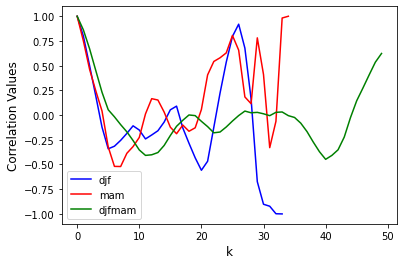

In [25]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.autocorr.html
# calculate p-value based on autocorrelation
auto_corr_djf = []
auto_corr_mam = []
auto_corr_djfmam = []
for i in np.arange(50):
    auto_corr_djf.append(data_roll_djf.AO.autocorr(lag=i))
    auto_corr_mam.append(data_roll_mam.AO.autocorr(lag=i))
    auto_corr_djfmam.append(data_roll_djfmam.AO.autocorr(lag=i))

plt.plot(np.arange(50), auto_corr_djf, 'b', label='djf')
plt.plot(np.arange(50), auto_corr_mam, 'r', label='mam')
plt.plot(np.arange(50), auto_corr_djfmam, 'g', label='djfmam')
plt.ylabel('Correlation Values', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.legend()
plt.show()

In [26]:
# lag-1 correlations for all ts (annual)
var_lst = ['AR_ALL', 'AO', 'PDO', 'ENSO', 'SH']
auto_corr_djf = []
auto_corr_mam = []
auto_corr_djfmam = []
for i, vr in enumerate(var_lst):
    auto_corr_djf.append(new_djf[vr].autocorr(lag=1))
    auto_corr_mam.append(new_mam[vr].autocorr(lag=1))
    auto_corr_djfmam.append(new_djfmam[vr].autocorr(lag=1))
    print(vr, new_djf[vr].autocorr(lag=1), new_mam[vr].autocorr(lag=1), new_djfmam[vr].autocorr(lag=1))


AR_ALL 0.39795164828561336 0.022066544966712755 0.2829097855364854
AO 0.14312483190195924 0.006638105633323437 0.1340603837320891
PDO 0.3239830542137262 0.4057542234355101 0.6345197723848492
ENSO -0.023370172599398487 0.21769707897364898 0.5412854243304761
SH -0.01289896128545756 -0.01692741255601124 0.5025858251143682


In [27]:
# lag-1 correlations for all ts (5-year running mean)
auto_corr_djf = []
auto_corr_mam = []
auto_corr_djfmam = []
for i, vr in enumerate(var_lst):
    auto_corr_djf.append(data_roll_djf[vr].autocorr(lag=1))
    auto_corr_mam.append(data_roll_mam[vr].autocorr(lag=1))
    auto_corr_djfmam.append(data_roll_djfmam[vr].autocorr(lag=1))
    print(vr, data_roll_djf[vr].autocorr(lag=1), data_roll_mam[vr].autocorr(lag=1), data_roll_djfmam[vr].autocorr(lag=1))

AR_ALL 0.901551906013414 0.8041498450206442 0.8990616095569125
AO 0.7995050432848553 0.7504464131949842 0.8620141760450553
PDO 0.8907857319401653 0.8722216736608098 0.9375013719549464
ENSO 0.6630394880575643 0.8107423493132617 0.86045645081089
SH 0.8146193208472157 0.7836755842082618 0.8901667509966702


/home/nash/DATA/repositories/AR_types/figs/artype_ao_5yrmean.png


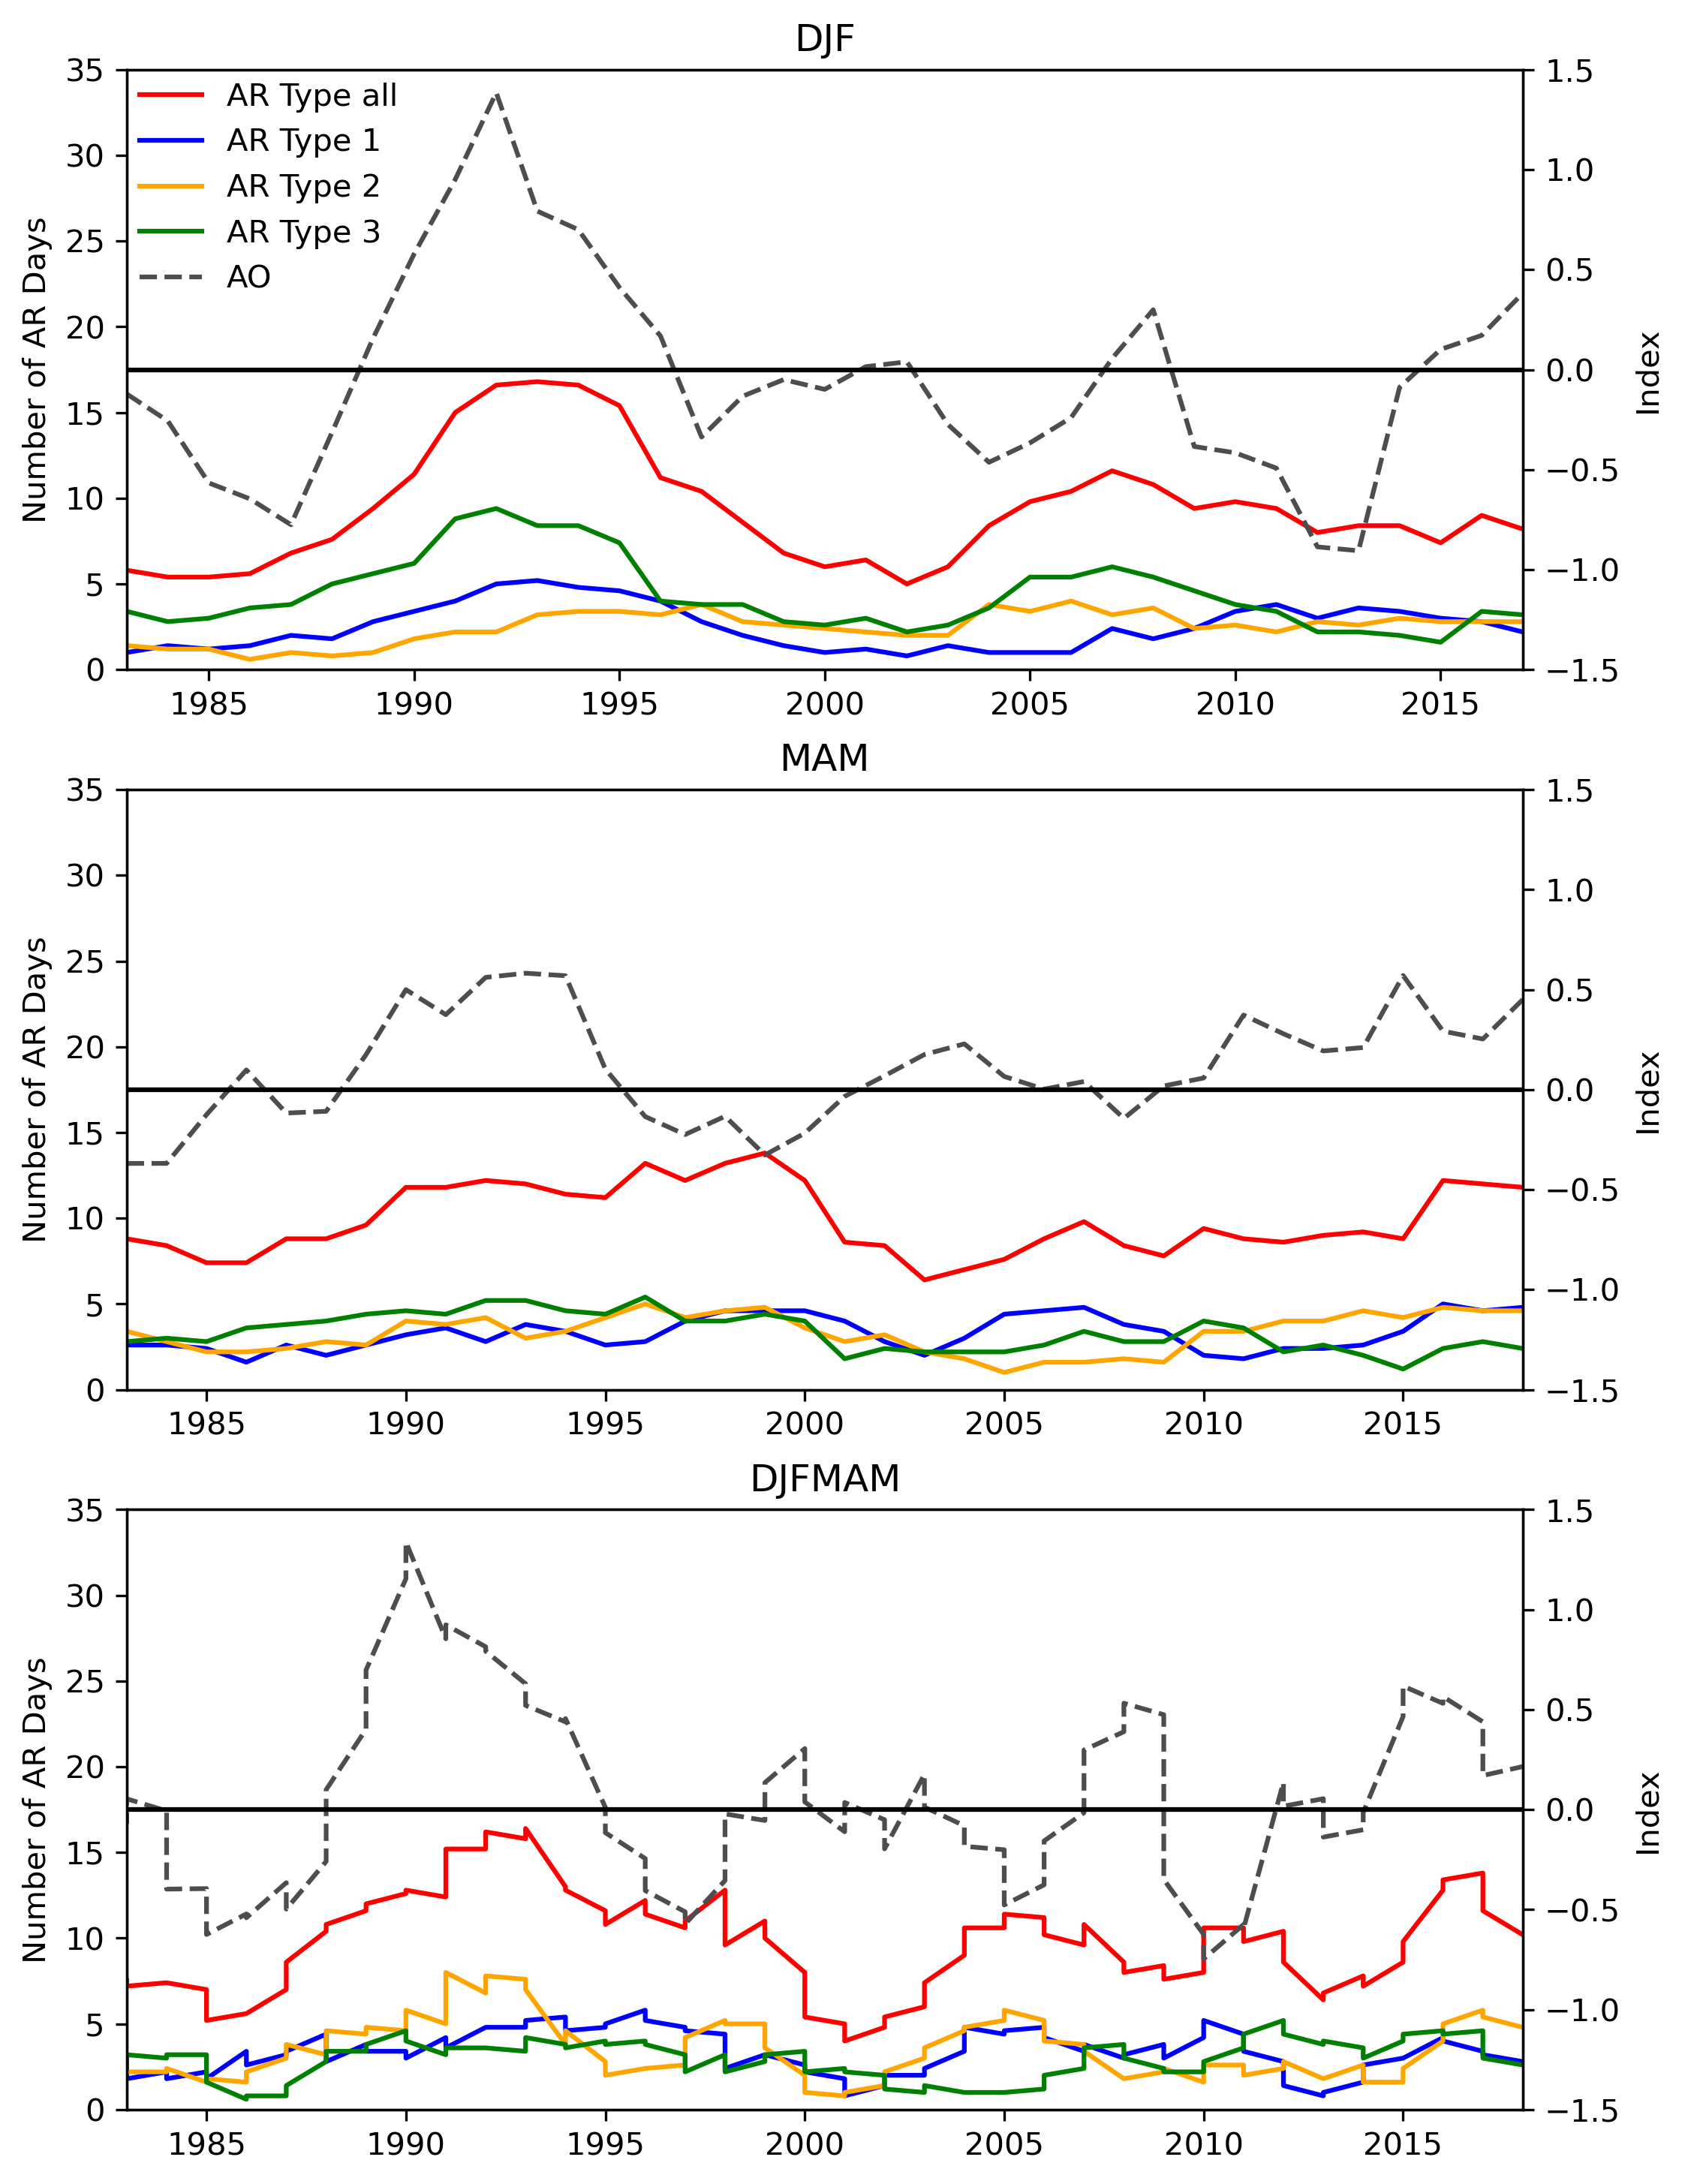

<Figure size 2400x3600 with 0 Axes>

In [30]:
# set up plot
data_lst = [data_roll_djf, data_roll_mam,  data_roll_djfmam]
data_lst2 = [new_djf, new_mam, new_djfmam]
plt_labels = ['DJF', 'MAM', 'DJFMAM']
legend_vis = [True, False, False]

# set up figure
outfile = path_to_figs + 'artype_ao_5yrmean' + '.png'
fig = plt.figure()
fig.set_size_inches((8.0,12.0))
fig.dpi = 300
nrows = 3
ncols = 1
nplots = nrows*ncols

alph = 0.2

for i in np.arange(nplots):
    ax = plt.subplot(nrows, ncols, i+1)

    
    ### Plot 5-year running mean values ###
    # lines on left axis
    data = data_lst[i]
    time = data.index.year
    lns1 = ax.plot(time, data.AR_ALL, color='red', label='AR Type all')
    lns2 = ax.plot(time, data.AR_CAT1, color="blue", label='AR Type 1')
    lns3 = ax.plot(time, data.AR_CAT2, color="orange", label='AR Type 2')
    lns4 = ax.plot(time, data.AR_CAT3, color="green", label='AR Type 3')
    ax.grid(False)
    # lines on right axis
    ax2 = ax.twinx()
    lns5 = ax2.plot(time, data.AO, color=(0.6/2.0, 0.6/2.0, 0.6/2.0), linestyle='--', label='AO')
#     lns6 = ax2.plot(time, data.sh, color=(0.8/2.0, 0.8/2.0, 0.8/2.0), linestyle=':', label='SH')
#     lns7 = ax2.plot(time, data.pdo, color=(1./2.0, 1./2.0, 1./2.0), linestyle='-.', label='PDO')
#     lns8 = ax2.plot(time, data.enso, color=(1.2/2.0, 1.2/2.0, 1.2/2.0), linestyle='-', label='ENSO')
    ax2.axhline(0, color='k')

#     ### Plot annual values ###
#     data = data_lst2[i]
#     time = data.index.year
#     # lines on left axis
#     lns12 = ax.plot(time, data.AR_ALL, color='red', label='AR Type all', alpha=alph)
#     lns22 = ax.plot(time, data.AR_CAT1, color="blue", label='AR Type 1', alpha=alph)
#     lns32 = ax.plot(time, data.AR_CAT2, color="orange", label='AR Type 2', alpha=alph)
#     lns42 = ax.plot(time, data.AR_CAT3, color="green", label='AR Type 3', alpha=alph)
#     # lines on right axis
#     lns52 = ax2.plot(time, data.AO, color=(0.6/2.0, 0.6/2.0, 0.6/2.0), linestyle='--', label='AO', alpha=alph)
    
    # labels
#     ax.set_xlabel("Time (year)")
    ax.set_ylabel(r"Number of AR Days")
    ax2.set_ylabel(r"Index")
    ax2.set_ylim(-1.5, 1.5)
    ax.set_ylim(0,35)
    ax.set_xlim(time[0]+4,time[-1])
    plt.title(plt_labels[i])
    
    # legend for all lines
    lns = lns1+lns2+lns3+lns4+lns5
    labs = [l.get_label() for l in lns]
    # ax.legend(lns, labs, frameon=False, ncol=1, bbox_to_anchor=(1.1, 1), loc='upper left')

    # Put the legend out of the figure
    plt.legend(lns, labs, loc='upper left', borderaxespad=0., frameon=False).set_visible(legend_vis[i])

# Save the figure
fig.savefig(outfile, bbox_inches='tight', dpi=fig.dpi)
fig.clf()

print(outfile)
display(Image(outfile))